# Worksheet 17

Name: Po-Han Lu
UID: U32967805

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

1. Gather user interactions with items (in this case, movies) in a binary form.
2. Construct a User-Item Matrix where:
  * Rows represent users.
  * Columns represent items.
  * Cells contain binary values: 1 if the user liked the item, 0 if the user disliked it.
3. Compute the Jaccard similarity.
4. Generate recommendations by:
  * Identifying items that each user has not rated.
  * Calculating a predicted score for each unrated item by aggregating the similarities of rated items, weighted by the user's ratings.
  * Sorting these items by their predicted scores in descending order and generating the top K recommendations.

b) Describe 3 challenges of building a recommender system

1. Sparse Data: The user-item interaction data is often sparse, meaning there are more items than ratings, which complicates the recommendation process.
2. Scalability and Performance: As the number of users and items increases, the computational demands for generating recommendations also increase, necessitating efficient algorithms to maintain performance.
3. Cold Start Problem: Recommender systems face difficulties with new users or items that lack historical data. In such cases, they have to rely on metadata or demographic information to make initial recommendations.

c) Why is SVD not an option for collaborative filtering?

Traditional Singular Value Decomposition (SVD) is not directly applicable to collaborative filtering due to the sparse nature of user-item interaction matrices, where most entries are missing. SVD requires a fully populated matrix, which is not usually the case in real-world scenarios. Moreover, traditional SVD struggles with scalability and lacks the flexibility to integrate additional user or item metadata. As a result, adaptations like FunkSVD or SVD++ have been developed to handle missing values and incorporate additional contextual information.

d) Use the code below to train a recommender system on a dataset of amazon movies

C:\Users\lupohan\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
C:\Users\lupohan\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


Kaggle RMSE =  3.309682764254


C:\Users\lupohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


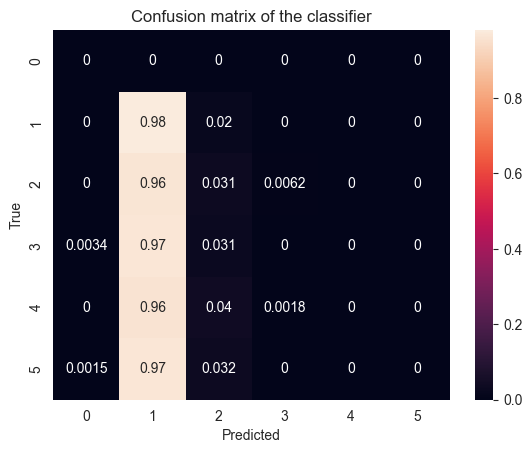

In [1]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
    init_df.drop(['Score'], axis=1),
    init_df['Score'],
    test_size=1/4.0,
    random_state=0
)

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
# param_grid = ParamGridBuilder().addGrid(
# als.rank, [10, 50]).addGrid(
# als.regParam, [.1]).addGrid(
# # als.maxIter, [10]).build()
# evaluator = RegressionEvaluator(
# metricName="rmse",
# labelCol="Score", 
# # predictionCol="prediction")
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
# cv_fit = cv.fit(df)
# rec_sys = cv_fit.bestModel

rec_sys = als.fit(df)
# rec_sys.save('rec_sys.obj') # so we don't have to re-train it
rec = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']]))
rec_pd = rec.toPandas()
X_test_processed = X_test_processed.merge(rec_pd[['UserId_fact', 'ProductId_fact', 'prediction']],
                                          how='left',
                                          on=['UserId_fact', 'ProductId_fact'])
X_test_processed.rename(columns={'prediction': 'Score'}, inplace=True)
# Use the mean of the training set to fill in missing values to handle the cold start problem.
X_test_processed['Score'].fillna(X_test_processed['Score'].mean(), inplace=True)
# Since all ratings are integers, round the predictions to the nearest integer.
X_test_processed['Score'] = X_test_processed['Score'].round().astype(int)




print("Kaggle RMSE = ", mean_squared_error(X_test_processed['Score'], Y_test, squared=False))

cm = confusion_matrix(Y_test, X_test_processed['Score'], normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()